# Get experiments

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cloudpickle

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

In [3]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


# Extend the experiment df with the experiment processed results

In [4]:
import numpy as np 

# TODO: Refactor all these functions to take into account that we also have abs spectra now

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

def smooth_spectrum(x, y, window=4):
    y = np.array(y)
    y_smooth = np.zeros_like(y)
    for i in range(len(y)):
        if i < window:
            y_smooth[i] = np.mean(y[:i+window])
        elif i > len(y) - window:
            y_smooth[i] = np.mean(y[i-window:])
        else:
            y_smooth[i] = np.mean(y[i-window:i+window])
    return x, y_smooth.tolist()

In [5]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            x, y = smooth_spectrum(x, y)
            fl_int_norm = [yi/max(y) for yi in y]
            fl_auc_total = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
            fl_wvl, fl_int = x[:], y[:]

        if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
            df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
            x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
            x, y = smooth_spectrum(x, y)
            abs_int_norm = [yi/max(y) for yi in y]
            abs_auc_total = get_area_under_peaks(x, y)
            abs_wvl, abs_int = x[:], y[:]
            # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
            abs_s = df[df['nm'] == 430][' A'].values[0]
            fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
            fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
            qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
        else:
            print(f"File not available: Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            abs_int_norm = None
            abs_auc_total = None
            abs_wvl, abs_int = None, None
            qy = -1

        results_df = pd.DataFrame({'Temperature(C)': [T], 
                                    'Doping(%)': [d], 
                                    'Time(min)': [t], 
                                    'Peak1': [peaks[0]], 
                                    'Peak2': [peaks[1]], 
                                    'Area1': [areas[0]], 
                                    'Area2': [areas[1]],
                                    'QY': [qy],
                                    # 'Distance_peaks': [peaks[1]-peaks[0]],
                                    # 'ratioP2P1': [areas[1]/areas[0]],
                                    'Fl_Wavelengths': [fl_wvl],
                                    'Fluorescence': [fl_int],
                                    'Fluorescence_norm': [fl_int_norm],
                                    'Abs_Wavelengths': [abs_wvl],
                                    'Absorbance': [abs_int],
                                    'Absorbance_norm': [abs_int_norm]
                                    }) # we can add other labels here
        new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_data.csv', index=False)

File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/50-5-10.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/0-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/50-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-1-180.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-5-180.csv


# Entire espectra

In [6]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/fl_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                x, y = smooth_spectrum(x, y)
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')

new_columns = ['Wavelength(nm)', 'Absorbance', 'Absorbance_norm']
with open('Data/abs_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
                df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
                df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                x, y = smooth_spectrum(x, y)
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')
            else:
                pass

# Creating bolift pool

In [7]:
experiments.head()

,Dimension1(nm),Dimension2(nm),OD,Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),AgSol(uL),Time(min),Temperature(C),Experiment
0,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,1.25,1.4,60,25,1_NPL-4_(5-31-22)
1,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,2.50,3.4,60,25,1_NPL-4_(5-31-22)
2,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,5.00,6.8,60,25,1_NPL-4_(5-31-22)
3,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,10.00,13.7,60,25,1_NPL-4_(5-31-22)
4,18.8,14.04,100x,0.175,0.25,1.75,0.0007,3.5,20,8,0.25,3.0,60,25,2_NPL-4_(6-1-22)


In [8]:
import itertools
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

def get_partial_pool(experiments, feats):
    dict_df = experiments.groupby(by=feats).size().reset_index()[feats].to_dict()
    return [{k:v[i] for (k,v) in zip(dict_df.keys(), dict_df.values())} for i in range(len(list(dict_df.values())[0]))]

def explode_dict(dict):
    return [{k:v[i] for (k,v) in zip(dict.keys(), dict.values())} for i in range(len(list(dict.values())[0]))]

features = experiments.keys()[:-1]
feats_1=features[0:2]
feats_2=features[2:6]
feats_3=features[6:12]
feats_4=features[12:14]

pool_p1 = get_partial_pool(experiments, feats_1.to_list())
pool_p2 = get_partial_pool(experiments, feats_2.to_list())
pool_p3 = get_partial_pool(experiments, feats_3.to_list())
pool_p4 = {
    "Time(min)": [10, 60, 180],
    "Temperature(C)": [0, 25, 50],
}
pool_p4 = [{"Time(min)": v1, "Temperature(C)": v2} for (v1,v2) in itertools.product(*pool_p4.values())]


iter = itertools.product(pool_p1, pool_p2, pool_p3, pool_p4)

pool_list = []
for props in iter:
    d = {}
    for prop in props:
        d.update(prop)
    pool_list.append(prompt_template.format(**d))

with open('Data/pool_chunk.txt', 'w') as output:
    output.write('\n'.join(pool_list))

pool = bolift.Pool(pool_list)
cloudpickle.dump(pool, open('Data/pool_chunk.pkl', 'wb'))

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

# df = cloudpickle.load(open("Data/pool_processed.pkl", "rb"))
df = pd.read_csv('Data/pool_processed.csv')

prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL):.4f} mL of MeOH and {H2O_vol(mL):.4f} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL):.4f} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

pool_list = []
for i, row in df.iterrows():
    pool_list.append(prompt_template.format(**row.to_dict()))

with open('Data/pool_processed.txt', 'w') as output:
    output.write('\n'.join(pool_list))

pool = bolift.Pool(pool_list)
cloudpickle.dump(pool, open('Data/pool_processed.pkl', 'wb'))

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-embedding-ada-002 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 1000000 / min. Current: 873659 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-embedding-ada-002 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 1000000 / min. Current: 917301 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-embedding-ada-002 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 

KeyboardInterrupt: 

# Data analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


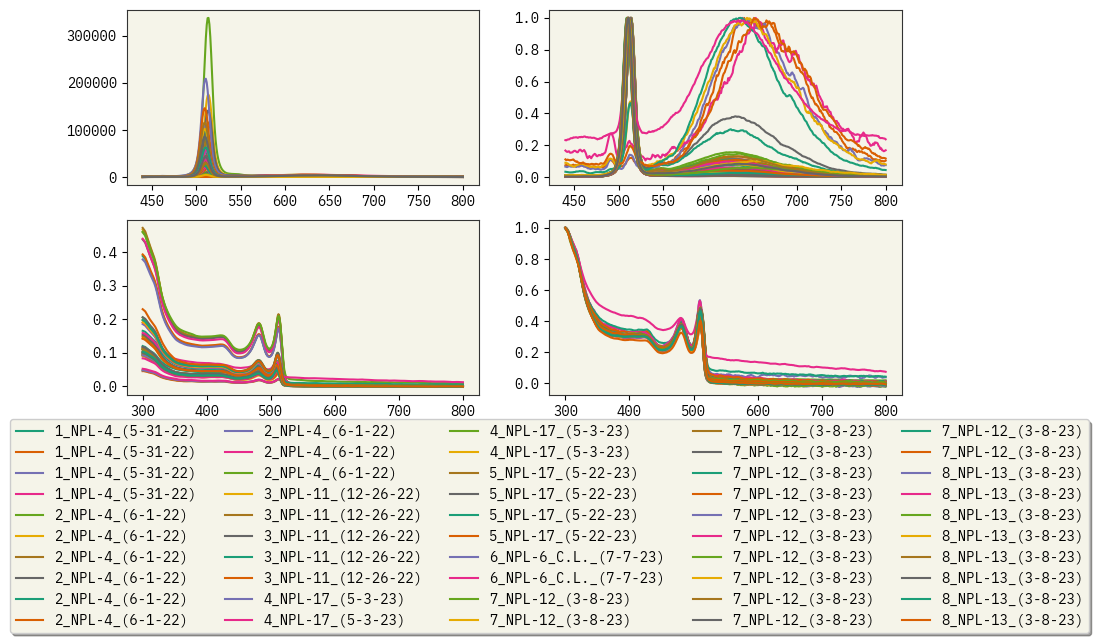

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

df = pd.read_csv('Data/fl_spectra_data.csv')
for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    axs[0, 0].plot(df['Wavelength(nm)'], df['Fluorescence'], label=group[0])
    axs[0, 1].plot(df['Wavelength(nm)'], df['Fluorescence_norm'], label=group[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.1),
          fancybox=True, shadow=True, ncol=5)

df = pd.read_csv('Data/abs_spectra_data.csv')
for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    axs[1, 0].plot(df['Wavelength(nm)'], df['Absorbance'], label=group[0])
    axs[1, 1].plot(df['Wavelength(nm)'], df['Absorbance_norm'], label=group[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()


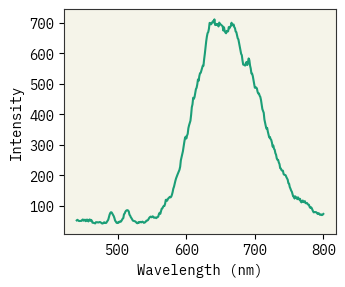

In [8]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

sample = df.iloc[1]
w = [float(a) for a in sample['Fl_Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample['Fluorescence'][1:-1].split(',')]
# w = [float(a) for a in sample['Abs_Wavelengths'][1:-1].split(',')]
# i = [float(a) for a in sample['Absorbance'][1:-1].split(',')]

plt.plot(w, i, color="C0")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
# plt.ylabel("Absorbance")
plt.show()

In [9]:
df[['Peak1', "Peak2", "Area1", "Area2", "QY"]].describe()

,Peak1,Peak2,Area1,Area2,QY
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,511.392857,624.035714,0.603398,0.330170,0.075379
std,3.189064,17.620199,0.255137,0.198739,0.413586
min,491.000000,550.000000,0.055621,0.057340,-1.000000
25%,510.000000,620.000000,0.498410,0.169117,0.063311
50%,511.000000,625.000000,0.640734,0.304475,0.120473
75%,513.000000,632.000000,0.807970,0.437855,0.239518
max,514.000000,654.000000,0.930336,0.781279,1.010844


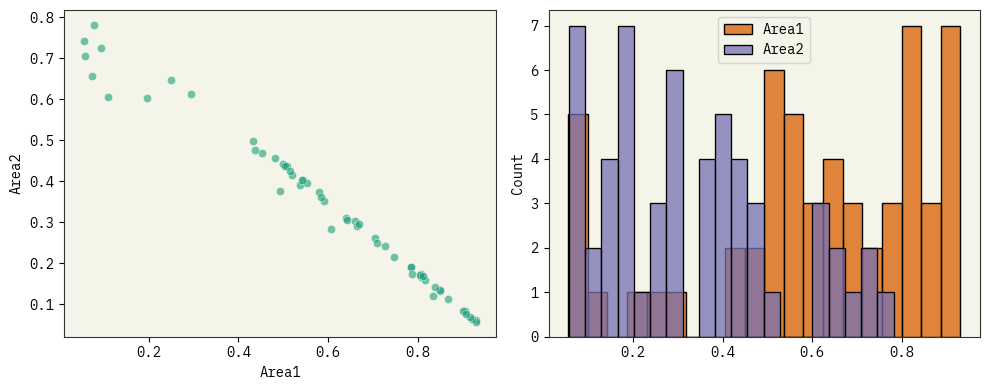

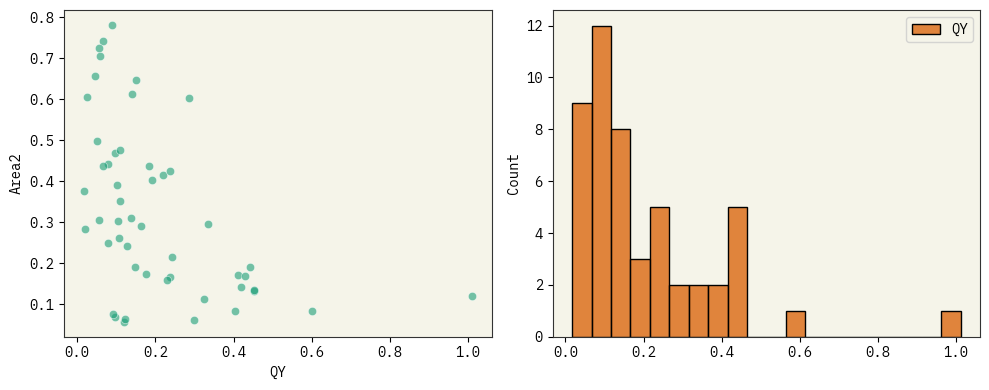

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels_auc1 = df['Area1'].to_list()
labels_auc2 = df['Area2'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(labels_auc1, labels_auc2, alpha=0.6, color='C0', edgecolors='w', linewidth=0.5)
ax1.set_xlabel('Area1')
ax1.set_ylabel('Area2')

sns.histplot(labels_auc1, bins=20, label='Area1', ax=ax2, color='C1')
sns.histplot(labels_auc2, bins=20, label='Area2', ax=ax2, color='C2')
ax2.legend()

plt.tight_layout()
plt.show()


labels_qy = df[df['QY'] >= 0]['QY'].to_list()
labels_auc2 = df[df['QY'] >= 0]['Area2'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(labels_qy, labels_auc2, alpha=0.6, color='C0', edgecolors='w', linewidth=0.5)
ax1.set_xlabel('QY')
ax1.set_ylabel('Area2')

sns.histplot(labels_qy, bins=20, label='QY', ax=ax2, color='C1')
ax2.legend()

plt.tight_layout()
plt.show()



In [11]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd
import numpy as np
import base64
from io import BytesIO

x_name = "QY"
y_name = "Area2"

plotly_df = pd.DataFrame({
    f"{x_name}": df[x_name].tolist(),
    f"{y_name}": df[y_name].tolist(),
    "f": df[x_name] * df[y_name],
    "customdata": list(zip(
        df['Fl_Wavelengths'].tolist(), 
        df['Fluorescence'].tolist(),
        [f"{exp}:\nT={int(T)}C; doping={f_(d)}%; time={int(t)}s" for exp,T,d,t in df[['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']].values.tolist()],
        ))
})
plotly_df = plotly_df[plotly_df['QY'] >= 0]
fig = px.scatter(plotly_df, x=x_name, y=y_name, color='f', custom_data=["customdata"])
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=10)

# Create dash app
app = dash.Dash(__name__)

# Create app layout to show dash graph
app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id="graph_interaction",
            figure=fig,
        )
    ], style={'width': '60%', 'display': 'inline-block'}),

    html.Div([
        html.Img(id='image', src='')
    ], style={'width': '35%', 'display': 'inline-block', 'padding': "20px"})
])

def plot_and_encode_image(data):
    wv = list(map(float, data[0].strip('[]').split(',')))
    fl = list(map(float, data[1].strip('[]').split(',')))
    title = data[2]
    fig, ax = plt.subplots(figsize=(6, 4.5))
    fig.suptitle(title)
    ax.plot(wv, fl)
    plt.close(fig)
    
    # Convert plot to PNG image
    buf = BytesIO()
    fig.savefig(buf, format="png")
    
    # Encode PNG image to base64 string
    data = base64.b64encode(buf.getbuffer()).decode("utf8")
    return "data:image/png;base64,{}".format(data)

@app.callback(
    Output('image', 'src'),
    Input('graph_interaction', 'hoverData'))
def update_image(hoverData): 
    if hoverData:
        data_to_plot = hoverData["points"][0]["customdata"][0]
        return plot_and_encode_image(data_to_plot)
    else:
        raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=True)